## Compare with model results and interpretability from DeepMol

Load the dataset from a CSV

In [93]:
from deepmol.compound_featurization import TwoDimensionDescriptors
from collections import Counter
from deepmol.datasets import SmilesDataset
from deepmol.loaders.loaders import CSVLoader
import pandas as pd
from deepmol.imbalanced_learn import RandomUnderSampler
from deepmol.splitters.splitters import SingletaskStratifiedSplitter
from copy import deepcopy
from deepmol.models import SklearnModel
from sklearn.ensemble import RandomForestClassifier
from deepmol.metrics import Metric
from sklearn.metrics import roc_auc_score, accuracy_score
from deepmol.feature_importance import ShapValues

In [94]:
ds = pd.read_csv('data/tox21.csv')
ds.dropna(subset=['SR-p53'],inplace=True)
ds.fillna(0, inplace=True)
ds.drop('mol_id', axis=1, inplace=True)
ds.shape

(6774, 13)

In [95]:
ds.to_csv("data/deepmol_dataset.csv", sep=',', index=True,index_label="id", encoding='utf-8')

loader = CSVLoader(dataset_path='data/deepmol_dataset.csv',
                   smiles_field='smiles',
                   id_field='id',
                   labels_fields=['SR-p53'],
                   features_fields=['NR-AR','NR-AR-LBD','NR-AhR','NR-Aromatase','NR-ER','NR-ER-LBD','NR-PPAR-gamma','SR-ARE','SR-ATAD5','SR-HSE','SR-MMP'],
                   shard_size=6774,
                   mode='auto')

In [96]:
dataset = loader.create_dataset()
dataset.get_shape()

[16:47:35] WARNING: not removing hydrogen atom without neighbors


2024-05-18 16:47:36,548 — INFO — Assuming classification since there are less than 10 unique y values. If otherwise, explicitly set the mode to 'regression'!
2024-05-18 16:47:36,835 — INFO — Mols_shape: (6774,)
2024-05-18 16:47:36,837 — INFO — Features_shape: (6774, 11)
2024-05-18 16:47:36,838 — INFO — Labels_shape: (6774,)


((6774,), (6774, 11), (6774,))

Pre-processing


In [97]:
Counter(dataset.y)

Counter({0.0: 6351, 1.0: 423})

In [98]:
from deepmol.imbalanced_learn import RandomUnderSampler

d3 = deepcopy(dataset)
sampler = RandomUnderSampler(sampling_strategy=0.75, random_state=123, replacement=True)
d3 = sampler.sample(d3)

Counter(d3.y)   

Counter({0.0: 564, 1.0: 423})

In [99]:
splitter = SingletaskStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=d3, frac_train=0.7,
                                                                             frac_valid=0.15, frac_test=0.15)

Model: RandomForest

In [100]:
rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)

SklearnModel(model=RandomForestClassifier(),
             model_dir='C:\\Users\\Work\\AppData\\Local\\Temp\\tmplnnrzrfr')

In [101]:
model.evaluate(test_dataset, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.8085086747877445, 'accuracy_score': 0.825503355704698},
 {})

Model1: GraphConvModel

In [102]:
from deepmol.compound_featurization import ConvMolFeat

train_dataset_conv = ConvMolFeat(n_jobs=10).featurize(train_dataset, inplace=False)
test_dataset_conv = ConvMolFeat(n_jobs=10).featurize(test_dataset, inplace=False)
valid_dataset_conv = ConvMolFeat(n_jobs=10).featurize(valid_dataset, inplace=False)


In [103]:
from deepchem.models import GraphConvModel
from deepmol.models import DeepChemModel

model1 = DeepChemModel(model=GraphConvModel, epochs=100, verbose=1, n_tasks=1, graph_conv_layers=[32, 32], dense_layer_size=128)
model1.fit(train_dataset_conv)

In [104]:
model1.evaluate(test_dataset_conv, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.7476928755998523, 'accuracy_score': 0.7651006711409396},
 {})

In [105]:
model1.evaluate(valid_dataset_conv, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.6276041666666667, 'accuracy_score': 0.6554054054054054},
 {})

Model2 : GraphConvModel using graphs

In [160]:
ds = pd.read_csv('data/tox21.csv')
ds = deepcopy(ds)
ds_true = ds[ds['SR-p53'] == 1]
ds_false = ds[ds['SR-p53'] == 0]

ds_false = ds_false.sample(ds_true.shape[0])
ds = pd.concat([ds_true, ds_false])
ds.shape

(846, 14)

In [169]:
import deepchem as dc
smiles = dc.feat.MolGraphConvFeaturizer().featurize(ds['smiles'])
graph_ds = dc.data.NumpyDataset(X=smiles, y=ds['SR-p53'])

Failed to featurize datapoint 11, [Hg+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [173]:
atom_characteristics = {
    #RDKIT.CHEM.MOL CHARACTERISTICS
    'atomic_num': list(range(0, 119)),
    'chirality': ['CHI_UNSPECIFIED','CHI_TETRAHEDRAL_CW','CHI_TETRAHEDRAL_CCW','CHI_OTHER','CHI_TETRAHEDRAL','CHI_ALLENE','CHI_SQUAREPLANAR','CHI_TRIGONALBIPYRAMIDAL','CHI_OCTAHEDRAL'],
    'degree': list(range(0, 11)),
    'formal_charge': list(range(-5, 7)),
    'num_hs': list(range(0, 9)),
    'num_radical_electrons': list(range(0, 5)),
    'hybridization': ['UNSPECIFIED','S','SP','SP2','SP3','SP3D','SP3D2','OTHER'],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
}

bond_characteristics= {
    #RDKIT.CHEM.MOL CHARACTERISTICS
    'bond_type': ['UNSPECIFIED','SINGLE','DOUBLE','TRIPLE','QUADRUPLE','QUINTUPLE','HEXTUPLE','ONEANDAHALF','TWOANDAHALF','THREEANDAHALF','FOURANDAHALF','FIVEANDAHALF','AROMATIC','IONIC','HYDROGEN','THREECENTER','DATIVEONE','DATIVE','DATIVEL','DATIVER','OTHER','ZERO'],
    'stereo': ['STEREONONE','STEREOANY','STEREOZ','STEREOE','STEREOCIS','STEREOTRANS'],
    'is_conjugated': [False, True],
}

In [181]:
from torch_geometric.data import Data
import torch

def getAtrValue(atr,smiles):
    return ds.loc[ds['smiles'] == smiles, atr].iloc[0]

def molecule_to_graph(strsmiles,label,mol):

    xs = []
    additional_properties = []

    for atom in mol.GetAtoms():

        x = []
        x.append(atom_characteristics['atomic_num'].index(atom.GetAtomicNum()))
        x.append(atom_characteristics['chirality'].index(str(atom.GetChiralTag())))
        x.append(atom_characteristics['degree'].index(atom.GetTotalDegree()))
        x.append(atom_characteristics['formal_charge'].index(atom.GetFormalCharge()))
        x.append(atom_characteristics['num_hs'].index(atom.GetTotalNumHs()))
        x.append(atom_characteristics['num_radical_electrons'].index(atom.GetNumRadicalElectrons()))
        x.append(atom_characteristics['hybridization'].index(str(atom.GetHybridization())))
        x.append(atom_characteristics['is_aromatic'].index(atom.GetIsAromatic()))
        x.append(atom_characteristics['is_in_ring'].index(atom.IsInRing()))

        xs.append(x)

    x = torch.tensor(xs, dtype=torch.float).view(-1, 9)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e=[
            bond_characteristics['bond_type'].index(str(bond.GetBondType())),
            bond_characteristics['stereo'].index(str(bond.GetStereo())),
            bond_characteristics['is_conjugated'].index(bond.GetIsConjugated())
            ]
        e += [0] * (32 - len(e))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float).view(-1, 1)

    label = torch.tensor(label, dtype=torch.long)

    if edge_index.numel() > 0:
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y = label, smiles=strsmiles)

    #additional_properties.append(getAtrValue("NR-AR",data.smiles))
    #additional_properties.append(getAtrValue("NR-AR-LBD",data.smiles))
    #additional_properties.append(getAtrValue("NR-AhR",data.smiles))
    #additional_properties.append(getAtrValue("NR-Aromatase",data.smiles))
    #additional_properties.append(getAtrValue("NR-ER",data.smiles))
    #additional_properties.append(getAtrValue("NR-ER-LBD",data.smiles))
    #additional_properties.append(getAtrValue("NR-PPAR-gamma",data.smiles))
    #additional_properties.append(getAtrValue("SR-ARE",data.smiles))
    #additional_properties.append(getAtrValue("SR-ATAD5",data.smiles))
    #additional_properties.append(getAtrValue("SR-HSE",data.smiles))
    #additional_properties.append(getAtrValue("SR-MMP",data.smiles))
    #additional_properties = torch.tensor(additional_properties, dtype=torch.long).view(-1, 11)

    data.additionalproperties = additional_properties
    return data 

In [183]:
process_func = lambda mols: molecule_to_graph(mols['smiles'], mols['SR-p53'], Chem.MolFromSmiles(mols['smiles']))
list_data = list(map(process_func,ds.iloc))
list_data

[Data(x=[21, 9], edge_index=[2, 44], edge_attr=[44, 1], y=1, smiles='O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1', additionalproperties=[0]),
 Data(x=[12, 9], edge_index=[2, 24], edge_attr=[24, 1], y=1, smiles='Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl', additionalproperties=[0]),
 Data(x=[24, 9], edge_index=[2, 46], edge_attr=[46, 1], y=1, smiles='CCC(COC(=O)CCS)(COC(=O)CCS)COC(=O)CCS', additionalproperties=[0]),
 Data(x=[17, 9], edge_index=[2, 36], edge_attr=[36, 1], y=1, smiles='C[C@H]1O[C@@H](n2cc(F)c(=O)[nH]c2=O)[C@H](O)[C@@H]1O', additionalproperties=[0]),
 Data(x=[18, 9], edge_index=[2, 38], edge_attr=[38, 1], y=1, smiles='CC1=C(C(=O)Nc2ccccc2)S(=O)(=O)CCO1', additionalproperties=[0]),
 Data(x=[24, 9], edge_index=[2, 56], edge_attr=[56, 1], y=1, smiles='C[C@]12CC[C@H]3[C@@H](CC[C@@]45O[C@@H]4C(O)=C(C#N)C[C@]35C)[C@@H]1CC[C@@H]2O', additionalproperties=[0]),
 Data(x=[19, 9], edge_index=[2, 40], edge_attr=[40, 1], y=1, smiles='CC(=O)Oc1cc(C)c(OC(C)=O)c2ccccc12', additionalproperties=[0]),
 Data(x=[2

((846,), (846,), (846,), (846,))

In [ ]:
from deepmol.compound_featurization import ConvMolFeat

train_dataset_conv = ConvMolFeat(n_jobs=10).featurize(train_dataset, inplace=False)
test_dataset_conv = ConvMolFeat(n_jobs=10).featurize(test_dataset, inplace=False)
valid_dataset_conv = ConvMolFeat(n_jobs=10).featurize(valid_dataset, inplace=False)


In [166]:
from deepchem.models import GCNModel

model = GCNModel(mode='classification', n_tasks=1,
                 batch_size=16, learning_rate=0.001)
loss = model.fit(graph_ds, nb_epoch=5)

AttributeError: 'numpy.ndarray' object has no attribute 'to_dgl_graph'

Explaining Model1

In [106]:
from deepmol.compound_featurization import MACCSkeysFingerprint

patt_number = 91
mol_number = 2

prediction = model1.predict(test_dataset_conv)[mol_number]
actual_value = test_dataset_conv.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi_conv = test_dataset_conv.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

maccs_keys.draw_bit(smi_conv, patt_number)

Prediction:  0
Actual Value:  0.0
2024-05-18 16:48:17,963 — INFO — Pattern does not match molecule! Active bits: [ 39  40  48  49  51  55  58  59  60  61  64  67  73  81  88 102 106 112
 124 130 136 140 144 146 148 150 154 159 162 163 164 165]


In [107]:
patt_number = 80
MorganFingerprint().draw_bit(smi_conv, patt_number)

2024-05-18 16:48:17,984 — INFO — Bits ON: [140, 271, 350, 392, 441, 650, 694, 715, 762, 803, 827, 961, 992, 1004, 1063, 1088, 1199, 1309, 1380, 1476, 1750, 1873]


ValueError: Bit is off! Bits ON: [140, 271, 350, 392, 441, 650, 694, 715, 762, 803, 827, 961, 992, 1004, 1063, 1088, 1199, 1309, 1380, 1476, 1750, 1873]

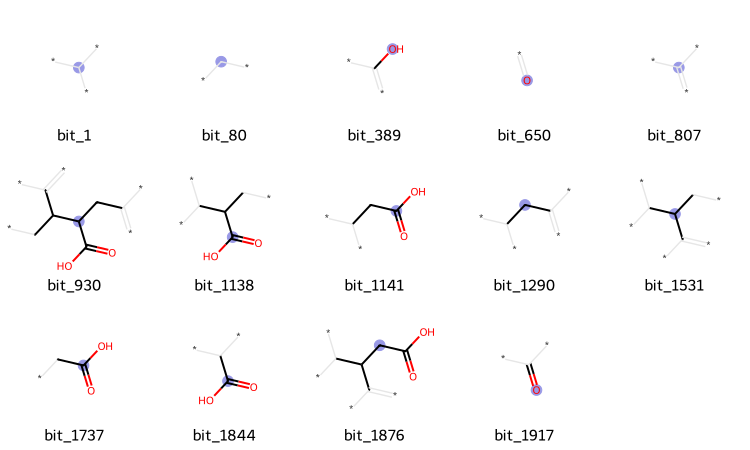

In [ ]:
MorganFingerprint().draw_bits(smi_conv, [1, 80, 389, 650, 807, 930, 1138, 1141, 1290, 1531, 1737, 1844, 1876, 1917])

Explaining Model

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but Ran

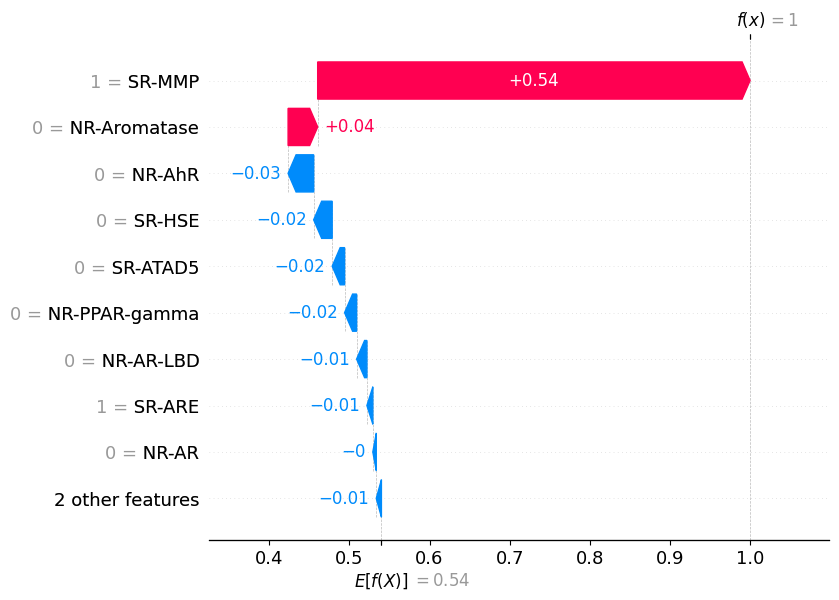

In [ ]:
# compute shap values
shap_calc = ShapValues()
shap_calc.fit(train_dataset, model)
shap_calc.sample_explanation_plot(index=1, plot_type='waterfall')

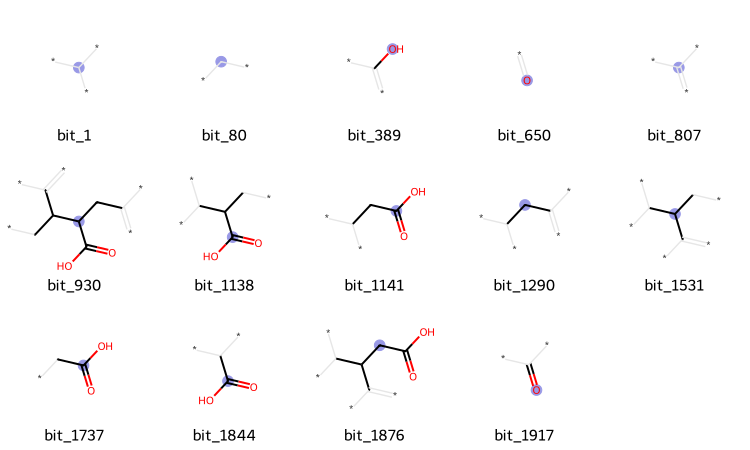

In [ ]:
MorganFingerprint().draw_bits(smi,  [1, 80, 389, 650, 807, 930, 1138, 1141, 1290, 1531, 1737, 1844, 1876, 1917])

Prediction:  0.0
Actual Value:  0.0


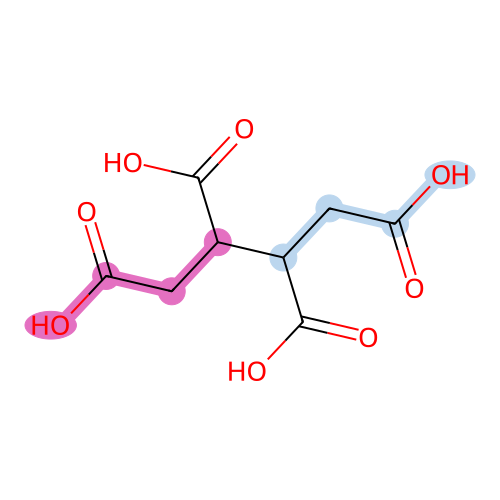

In [ ]:
patt_number = 104 
mol_number = 2

prediction = model.predict(test_dataset)[mol_number]
actual_value = test_dataset.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi = test_dataset.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

maccs_keys.draw_bit(smi, patt_number)

2024-05-17 23:27:10,670 — INFO — Bit 1 with 2 hits!


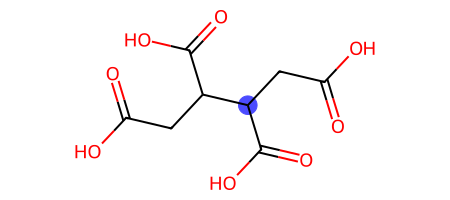

In [ ]:
patt_number = 1
MorganFingerprint().draw_bit(smi, patt_number)

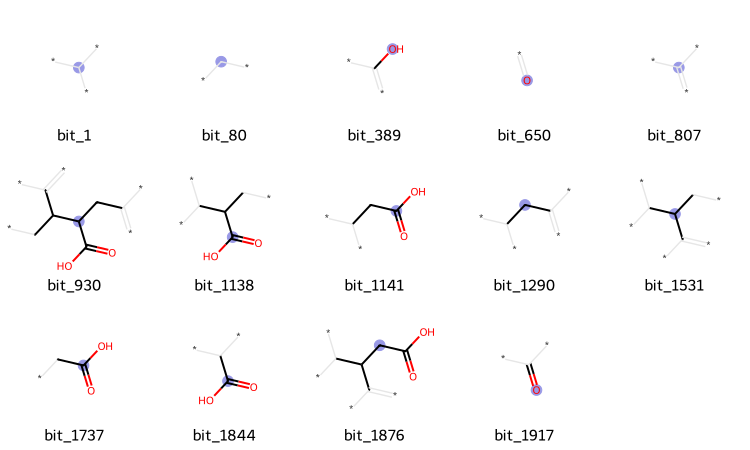

In [ ]:
MorganFingerprint().draw_bits(smi,  [1, 80, 389, 650, 807, 930, 1138, 1141, 1290, 1531, 1737, 1844, 1876, 1917])